In [329]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

In [330]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data.csv", index_col="date")

In [331]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [332]:
data.tail()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,2.81,3.08,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,2.84,3.12,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,2.87,3.15,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,2.84,3.14,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,2.91,3.22,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [333]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7931 non-null object
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null object
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(6), object(2)
memory usage: 557.6+ KB


In [334]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [335]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [336]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [382]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [383]:
data.columns
#values = data[['exukus'] + ['Volume (BTC)'] + ['Volume (Currency)']].values
#values = values.astype('float32')

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [384]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [385]:
values

array([[2.78210e+02, 8.05000e+00, 8.92000e+00, ..., 1.38200e+00,
        1.39780e+02, 5.94200e-01],
       [2.80170e+02, 8.06000e+00, 8.87000e+00, ..., 1.38640e+00,
        1.40450e+02, 5.95600e-01],
       [2.82160e+02, 7.97000e+00, 8.78000e+00, ..., 1.38830e+00,
        1.40600e+02, 5.97700e-01],
       ...,
       [2.71174e+03, 2.87000e+00, 3.15000e+00, ..., 1.41040e+00,
        1.12860e+02, 7.82500e-01],
       [2.74037e+03, 2.84000e+00, 3.14000e+00, ..., 1.39100e+00,
        1.12790e+02, 7.70800e-01],
       [2.72306e+03, 2.91000e+00, 3.22000e+00, ..., 1.38910e+00,
        1.13090e+02, 7.71300e-01]], dtype=float32)

In [386]:
look_back = 3 
time_steps = 1
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var1(t-2),var2(t-2),...,var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
7926,2656.100098,2.84,3.10,77.339996,1230.550049,1.4140,112.580002,0.7753,2705.570068,2.86,...,111.650002,0.7797,2641.250000,2.81,3.08,77.559998,1230.800049,1.4136,112.489998,0.7808
7927,2705.570068,2.86,3.14,77.300003,1230.800049,1.4116,112.540001,0.7796,2658.689941,2.81,...,112.489998,0.7808,2682.629883,2.84,3.12,75.680000,1225.400024,1.4061,112.760002,0.7855
7928,2658.689941,2.81,3.08,77.400002,1233.849976,1.4108,111.650002,0.7797,2641.250000,2.81,...,112.760002,0.7855,2711.739990,2.87,3.15,74.839996,1214.949951,1.4104,112.860001,0.7825
7929,2641.250000,2.81,3.08,77.559998,1230.800049,1.4136,112.489998,0.7808,2682.629883,2.84,...,112.860001,0.7825,2740.370117,2.84,3.14,71.250000,1231.150024,1.3910,112.790001,0.7708
7930,2682.629883,2.84,3.12,75.680000,1225.400024,1.4061,112.760002,0.7855,2711.739990,2.87,...,112.790001,0.7708,2723.060059,2.91,3.22,71.110001,1232.099976,1.3891,113.089996,0.7713


In [387]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)

/home/tjiang20/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [388]:
t = scaler.inverse_transform(scaled)
t[0]

array([278.20999146,   8.05000019,   8.92000008,  18.62999916,
       475.25      ,   1.38199997, 139.77999878,   0.59420002,
       280.17001343,   8.06000042,   8.86999989,  18.45000076,
       469.1000061 ,   1.38639998, 140.44999695,   0.59560001,
       282.16000366,   7.96999979,   8.77999973,  18.54999924,
       466.5       ,   1.38829994, 140.6000061 ,   0.5977    ,
       289.10998535,   7.78999996,   8.55000019,  18.62999916,
       449.        ,   1.40289998, 143.30000305,   0.61199999])

In [389]:
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [390]:
# train_t = scaler.inverse_transform(test)
# train_t[-1]

In [391]:
# split into input and outputs
train_X, train_y = train[:, :-8], train[:, -8:]
test_X, test_y = test[:, :-8], test[:, -8:]

In [392]:
train_X.shape

(5068, 24)

In [393]:
train_y.shape

(5068, 8)

In [394]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
train_y = train_y.reshape((train_y.shape[0], 1, train_y.shape[1]))
test_y = test_y.reshape((test_y.shape[0], 1, test_y.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(5068, 1, 24) (5068, 1, 8) (2173, 1, 24) (2173, 1, 8)


# Building the Model

In [395]:
multi_model = Sequential()
multi_model.add(LSTM(
    input_shape=(train_X.shape[1],train_X.shape[2]),
    return_sequences=True, units=train_X.shape[1]))

multi_model.add(LSTM(
    300,
    return_sequences=True))
multi_model.add(TimeDistributed(Dense(number_of_variables)))
multi_model.compile(loss="mse", optimizer="adam")
multi_history = multi_model.fit(train_X, train_y, epochs=150, batch_size=150, validation_data=(test_X, test_y), verbose=0, shuffle=False)




In [134]:
# multi_model = Sequential()
# multi_model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
# multi_model.add(Dense(1))
# multi_model.compile(loss='mae', optimizer='adam')

# # Callbacks
# from keras.callbacks import ModelCheckpoint

# weight_path="{}_weights.hdf5".format('market_lstm_model')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = False)
# callbacks_list = [checkpoint]


# multi_history = multi_model.fit(train_X, train_y, epochs=40, batch_size=150, validation_data=(test_X, test_y), 
#                                 verbose=1, shuffle=False)#, callbacks = callbacks_list)

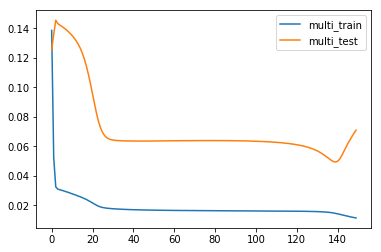

In [396]:
pyplot.plot(multi_history.history['loss'], label='multi_train')
pyplot.plot(multi_history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [397]:
yhat = multi_model.predict(test_X)

In [398]:
test_y.shape

(2173, 1, 8)

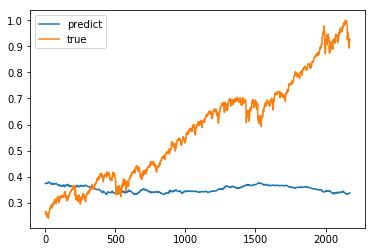

In [399]:
pyplot.plot(yhat[:,0][:,0], label='predict')
pyplot.plot(test_y[:,0][:,0], label='true')
pyplot.legend()
pyplot.show()

In [400]:
#reshape prediction
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [401]:
yhat = yhat.reshape((yhat.shape[0], yhat.shape[2]))

In [402]:
test_X.shape

(2173, 24)

In [403]:
inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

In [404]:
inv_yhat.shape

(2173, 32)

In [405]:
inv_yhat = scaler.inverse_transform(inv_yhat)

In [406]:
inv_yhat[-1]

array([2.68262988e+03, 2.83999991e+00, 3.11999989e+00, 7.56800003e+01,
       1.22540002e+03, 1.40610003e+00, 1.12760002e+02, 7.85499990e-01,
       2.71173999e+03, 2.86999989e+00, 3.15000010e+00, 7.48399963e+01,
       1.21494995e+03, 1.41040003e+00, 1.12860001e+02, 7.82500029e-01,
       2.74037012e+03, 2.83999991e+00, 3.14000010e+00, 7.12500000e+01,
       1.23115002e+03, 1.39100003e+00, 1.12790001e+02, 7.70799994e-01,
       1.13914815e+03, 3.03326817e+00, 4.47476116e+00, 1.08137218e+02,
       1.02685148e+03, 1.07934202e+00, 1.14260281e+02, 5.06802812e-01])

In [407]:
#inv_yhat[:,-8:].shape

In [408]:
inv_yhat = inv_yhat[:,-8:]

In [409]:
inv_yhat[0]

array([1.23768271e+03, 2.91668138e+00, 4.17383188e+00, 7.75065287e+01,
       7.39238105e+02, 1.28185731e+00, 1.10714619e+02, 5.50911668e-01])

In [410]:
#reshape actual
test_y = test_y.reshape((test_y.shape[0], test_y.shape[2]))

In [411]:
test_y.shape

(2173, 8)

In [412]:
inv_y = concatenate((test_X[:, :], test_y), axis=1)

In [413]:
inv_y = scaler.inverse_transform(inv_y)

In [414]:
inv_y[-1]

array([2.68262988e+03, 2.83999991e+00, 3.11999989e+00, 7.56800003e+01,
       1.22540002e+03, 1.40610003e+00, 1.12760002e+02, 7.85499990e-01,
       2.71173999e+03, 2.86999989e+00, 3.15000010e+00, 7.48399963e+01,
       1.21494995e+03, 1.41040003e+00, 1.12860001e+02, 7.82500029e-01,
       2.74037012e+03, 2.83999991e+00, 3.14000010e+00, 7.12500000e+01,
       1.23115002e+03, 1.39100003e+00, 1.12790001e+02, 7.70799994e-01,
       2.72306006e+03, 2.91000009e+00, 3.22000003e+00, 7.11100006e+01,
       1.23209998e+03, 1.38909996e+00, 1.13089996e+02, 7.71300018e-01])

In [415]:
#inv_y[:,-8:].shape

In [416]:
inv_y = inv_y[:,-8:]

In [417]:
inv_y[:,0].shape

(2173,)

In [423]:
rmse = sqrt(mean_squared_error(inv_y[:,3], inv_yhat[:,3]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25.045


In [422]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,3], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,3], name= 'Multi Predict Price')
py.iplot([multi_predict_chart, actual_chart])